Selected dataset: TwoPatterns
Dataset shape: Train: (1000, 128, 1), Test: (4000, 128, 1)


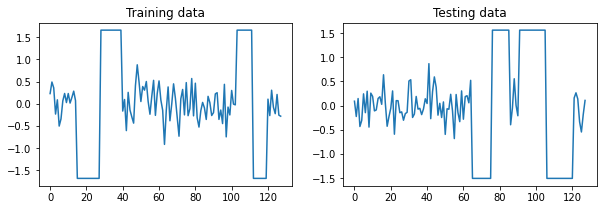

In [6]:
import sys
import py_ts_data

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import datetime
from auto_encoder import AutoEncoder, train_step

# Util functions
def min_max(data, feature_range=(0, 1)):
    """
    implements min-max scaler
    """
    min_v = feature_range[0]
    max_v = feature_range[1]
    max_vals = data.max(axis=1)[:, None, :]
    min_vals = data.min(axis=1)[:, None, :]
    X_std = (data - min_vals) / (max_vals - min_vals)
    return X_std * (max_v - min_v) + min_v

def normalize(data):
    """
    Z-normalize data with shape (x, y, z)
    x = # of timeseries
    y = len of each timeseries
    z = vars in each timeseres
    
    s.t. each array in [., :, .] (i.e. each timeseries variable)
    is zero-mean and unit stddev
    """
    sz, l, d = data.shape
    means = np.broadcast_to(np.mean(data, axis=1)[:, None, :], (sz, l, d))
    stddev = np.broadcast_to(np.std(data, axis=1)[:, None, :], (sz, l, d)) 
    return (data - means)/stddev

# Read in the data
DATASET_NAME = "TwoPatterns"
X_train, y_train, X_test, y_test, info = py_ts_data.load_data(DATASET_NAME, variables_as_channels=True)
print("Selected dataset: {}".format(DATASET_NAME))
print("Dataset shape: Train: {}, Test: {}".format(X_train.shape, X_test.shape))

# Generate a preview of the dataset
fig, axs = plt.subplots(1, 2, figsize=(10, 3))
axs[0].plot(X_train[0])
axs[0].set_title("Training data")
X_train = min_max(X_train, feature_range=(-1, 1))
axs[1].plot(X_test[0])
axs[1].set_title("Testing data")
X_test = min_max(X_test, feature_range=(-1, 1))
plt.show()


Training...
first code
(50, 256)
second code
(50, 256)
first output
(50, 128, 1)
first code
(50, 256)
second code
(50, 256)
first output
(50, 128, 1)
DONE


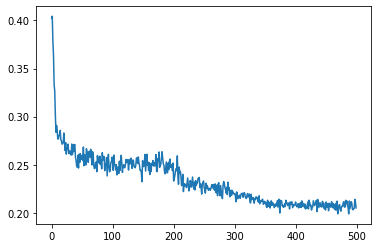

In [7]:
from itertools import tee
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras import layers,losses

# Define the model
class AutoEncoder(Model):
    def __init__(self, **kwargs):
        super(AutoEncoder, self).__init__()

        # Record params
        input_shape = kwargs["input_shape"]
        code_size = kwargs["code_size"]

        # Define the encoders
        # NOTE: Too much convolution smoothens the reconstructed signal. It's almost like having a moving average - the main event is preserved, however most of the details are flattened out.
        # NOTE: AveragePooling / MaxPooling / Dropout are bad for reconstruction.
        # NOTE: LSTM models are very good for predicting the future, but when the goal is having a compressed representation, RNNs are very lossy and not rich enought to produce good reconstructions.
        self.first_encoder = tf.keras.Sequential([
            layers.Input(shape=input_shape, dtype=tf.float32), # (128, 1)
            layers.Conv1D(64, 3, activation="relu", padding="same"),  # (128, 64)
            layers.Flatten(), # (8192, 1)
            layers.Dense(1024, activation="relu"), # (1024, 1)
            layers.Dense(256, activation="relu") # (265, 1)
            ])
        self.second_encoder = tf.keras.Sequential([
            layers.Input(shape=input_shape, dtype=tf.float32), # (128, 1)
            layers.Conv1D(64, 3, activation="relu", padding="same"),  # (128, 64)
            layers.Flatten(), # (8192, 1)
            layers.Dense(1024, activation="relu"), # (1024, 1)
            layers.Dense(256, activation="relu") # (265, 1)
            ])

        # Define the decoder
        self.decoder = tf.keras.Sequential([
            layers.Dense(1024, activation="relu"), # (1024, 1)
            layers.Dense(8192, activation="relu"), # (8192, 1)
            layers.Reshape((-1, 64)), # (128, 64)
            layers.Conv1D(1, 3, activation="sigmoid", padding="same") # (128, 1)
        ])

    def call(self, first_input, second_input, training=None):
        first_code = self.first_encoder(first_input)
        print("first code")
        print(first_code.shape) # TODO
        second_code = self.second_encoder(second_input)
        print("second code")
        print(second_code.shape) # TODO 
        first_output = self.decoder(first_code)
        print("first output")
        print(first_output.shape) # TODO 
        return first_code, second_code, first_output

# Define the losses
loss_tensor_codes = tf.keras.losses.MeanSquaredError()
loss_tensor_reconstruction = tf.keras.losses.MeanSquaredError() # TODO SBD
loss_metric_codes = tf.keras.metrics.Mean(name="Similarity loss")
loss_metric_reconstruction = tf.keras.metrics.Mean(name="Reconstruction loss")
error_metric_codes = tf.keras.metrics.MeanSquaredError()
error_metric_reconstruction = tf.keras.metrics.MeanSquaredError() # TODO SBD

# Define the optimizer
optimizer = tf.keras.optimizers.Nadam(learning_rate=0.00015)

# Define the training function
# NOTE: If using dropout, set training to False
@tf.function
def train_step(first_input, second_input, model, alpha=0.5):
    with tf.GradientTape() as tape:
        first_code, second_code, first_output = model(first_input, second_input)
        # similarity_loss = loss_tensor_codes(first_code, second_code) # TODO Use SBD
        reconstruction_loss = loss_tensor_reconstruction(first_input, first_output)
    gradients = tape.gradient([reconstruction_loss], model.trainable_variables)
    # gradients = tape.gradient([similarity_loss, reconstruction_loss], model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    # loss_metric_codes(similarity_loss)
    loss_metric_reconstruction(reconstruction_loss)

    # error_metric_codes(first_code, second_code)
    error_metric_reconstruction(first_input, first_output)

    return reconstruction_loss 

# Util: Pair creator
def pairwise(iterable):
    a, b = tee(iterable)
    next(b, None)
    return zip(a,b)

# Training
EPOCHS = 500
BATCH = 50
SHUFFLE_BUFFER = 100
ALPHA = 0.5
K = len(set(y_train))

kwargs = {
    "input_shape": (X_train.shape[1], X_train.shape[2]),
    "code_size": 16,
}

ae = AutoEncoder(**kwargs)

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER).batch(BATCH)

loss_history = []

print("Training...")

for epoch in range(EPOCHS):
    total_loss = 0
    for (first_input, _), (second_input, _) in pairwise(train_dataset):
        loss = train_step(first_input, second_input, ae, ALPHA)
    total_loss += loss
    loss_history.append(total_loss)
    print("Epoch {}: {}".format(epoch, total_loss), end="\r")

    loss_metric_codes.reset_states()
    loss_metric_reconstruction.reset_states()

    error_metric_codes.reset_states()
    error_metric_reconstruction.reset_states()
    
plt.plot(loss_history)

print("DONE")


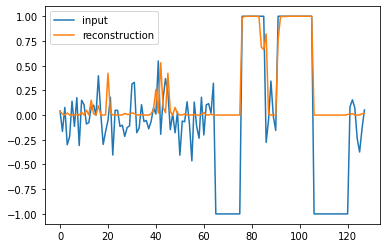

Mean L2 reconstruction loss: 5.396081447601318


In [8]:

# Testing reconstruction
code_test = ae.first_encoder(X_test)
decoded_test = ae.decoder(code_test)

plt.plot(X_test[0], label="input")
plt.plot(decoded_test[0], label="reconstruction")
plt.legend()
plt.show()

losses = []
for ground, predict in zip(X_test, decoded_test):
    losses.append(np.linalg.norm(ground - predict))
print("Mean L2 reconstruction loss: {}".format(np.array(losses).mean()))

In [9]:

# Testing similarity
from sklearn.neighbors import NearestNeighbors

def nn_dist(x, y):
    """
    Sample distance metric, here, using only Euclidean distance
    """
    x = x.reshape((40, 2))
    y = y.reshape((40, 2))
    return np.linalg.norm(x-y)

nn_x_test = X_test.reshape((-1, 80))
baseline_nn = NearestNeighbors(n_neighbors=10, metric=nn_dist).fit(nn_x_test)
code_nn = NearestNeighbors(n_neighbors=10).fit(code_test)

# For each item in the test data, find its 11 nearest neighbors in that dataset (the nn is itself)
baseline_11nn = baseline_nn.kneighbors(nn_x_test, 11, return_distance=False)
code_11nn     = code_nn.kneighbors(code_test, 11, return_distance=False)

# On average, how many common items are in the 10nn?
result = []
for b, c in zip(baseline_11nn, code_11nn):
    # remove the first nn (itself)
    b = set(b[1:])
    c = set(c[1:])
    result.append(len(b.intersection(c)))
print("Mean cluster size: {}".format(np.array(result).mean()))

Mean cluster size: 0.0175


In [10]:
# Save model
ae.first_encoder.save('sample_model/{}/encoder'.format(DATASET_NAME))
ae.decoder.save('sample_model/{}/decoder'.format(DATASET_NAME))

INFO:tensorflow:Assets written to: sample_model/TwoPatterns/encoder/assets
INFO:tensorflow:Assets written to: sample_model/TwoPatterns/decoder/assets
